In [265]:
import pandas as pd
import numpy as np
from py_geohash_any import geohash as gh
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%pylab inline
#!/usr/bin/env python
from __future__ import print_function


import random
import numpy as np
from collections import deque
import time
from keras.layers.normalization import BatchNormalization
import json
from collections import defaultdict
from keras.models import model_from_json
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import InputLayer
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD , Adam
import tensorflow as tf
import pickle
from operator import itemgetter
import sys
sys.path.insert(0, '../src/data')
import auxiliary_functions, make_dataset
from auxiliary_functions import convert_miles_to_minutes_nyc, list_of_output_predictions_to_direction
sys.path.insert(0, '../src/models-DQN')
from model_mlp import RLNYCTaxiCab

Populating the interactive namespace from numpy and matplotlib


/Users/jonathanhilgart/anaconda/envs/dl/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"




### Average speed of taxis in Manhattan
- In 2014, it dropped to 8.51 MPH. http://www.wnyc.org/story/traffic-speeds-slow-nyc-wants-curb-car-service-growth/
- 8.51 MPH is 3.80431 meters / second

### Geohash units are meters
- http://stackoverflow.com/questions/13448595/geohash-string-length-and-accuracy

In [3]:
#yellow_taxi_geohash_min_day
taxi_yellowcab_df, final_data_structure= make_dataset.main()

Opening up data
Group data
Creating the final data structure


In [392]:
# sample of the final data structure
final_data_structure[110]['Zct8R']

[(16.83410256410256, 20, 0.8417051281630428),
 (13.568571428571431, 20, 0.6784285713946502),
 (14.903888888888885, 20, 0.7451944444071845),
 (10.573636363636364, 10, 1.0573636362579),
 (10.49, 10, 1.0489999998951),
 (20.28375, 30, 0.6761249999774626),
 (13.92863636363637, 20, 0.696431818146997),
 (16.45078947368421, 20, 0.8225394736430836),
 (13.979999999999984, 20, 0.6989999999650492),
 (15.232596153846146, 20, 0.7616298076542258),
 (15.092857142857143, 20, 0.754642857105125),
 (20.539166666666667, 30, 0.6846388888660676),
 (17.402000000000005, 20, 0.8700999999564952),
 (15.51435897435897, 20, 0.7757179486791626),
 (13.809361702127658, 20, 0.6904680850718595),
 (13.942340425531903, 20, 0.6971170212417392),
 (14.408556701030914, 20, 0.7204278350155243),
 (13.827368421052636, 20, 0.6913684210180634),
 (19.789, 30, 0.6596333333113455),
 (14.559600000000003, 20, 0.7279799999636012),
 (14.088717948717953, 20, 0.7044358974006758),
 (13.443913043478263, 20, 0.6721956521403034),
 (13.97972602

In [5]:
# the data
taxi_yellowcab_df.head(10)

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,geohash_pickup,geohas_dropoff,jan_day,jan_minute,geohash_dropoff,trip_time_minutes
0,0,2,2016-01-01 00:00:00,2016-01-01 00:00:00,2,1.10,-73.990372,40.734695,1,N,...,0.0,0.0,0.3,8.8,Zct8X,dr5rsx,1,0,dr5rsx,10
1,1,2,2016-01-01 00:00:00,2016-01-01 00:00:00,5,4.90,-73.980782,40.729912,1,N,...,0.0,0.0,0.3,19.3,Zct8c,dr5rtk,1,0,dr5rtk,30
2,2,2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,10.54,-73.984550,40.679565,1,N,...,0.0,0.0,0.3,34.3,Zct5T,dr72j1,1,0,dr72j1,60
3,3,2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,4.75,-73.993469,40.718990,1,N,...,0.0,0.0,0.3,17.3,Zct8Q,dr5rkc,1,0,dr5rkc,30
4,4,2,2016-01-01 00:00:00,2016-01-01 00:00:00,3,1.76,-73.960625,40.781330,1,N,...,0.0,0.0,0.3,8.8,Zc4oK,dr5rue,1,0,dr5rue,10
5,5,2,2016-01-01 00:00:00,2016-01-01 00:18:30,2,5.52,-73.980118,40.743050,1,N,...,0.0,0.0,0.3,20.3,Zct9J,dr5ryh,1,18,dr5ryh,30
6,6,2,2016-01-01 00:00:00,2016-01-01 00:26:45,2,7.45,-73.994057,40.719990,1,N,...,0.0,0.0,0.3,27.3,Zct8Q,dr72hc,1,26,dr72hc,40
7,7,1,2016-01-01 00:00:01,2016-01-01 00:11:55,1,1.20,-73.979424,40.744614,1,N,...,0.0,0.0,0.3,10.3,Zct9J,dr5ru7,1,11,dr5ru7,10
8,8,1,2016-01-01 00:00:02,2016-01-01 00:11:14,1,6.00,-73.947151,40.791046,1,N,...,0.0,0.0,0.3,19.3,Zc4oj,dr72mz,1,11,dr72mz,40
9,9,2,2016-01-01 00:00:02,2016-01-01 00:11:08,1,3.21,-73.998344,40.723896,1,N,...,0.0,0.0,0.3,12.8,Zct8R,dr5rkp,1,11,dr5rkp,20


# Finding neighbors from a dropoff geohash
- use gh.neighbors
- Convert these neighbors to an output index from the neural network

In [6]:
gh.neighbors(taxi_yellowcab_df.geohash_dropoff[0])

{'e': 'dr5rsz',
 'n': 'dr5rs0',
 'ne': 'dr5rs2',
 'nw': 'dr5rse',
 's': 'dr5rsw',
 'se': 'dr5rsy',
 'sw': 'dr5rsa',
 'w': 'dr5rsb'}

In [7]:
# Dictionary to convert these distances into the output from the Neural Network
# Outputs are nine numbers which correspond to a direction to go in
# 0) NW 1) N                     2) NE
# 3) W  4) Stay in same geohash  5)E
# 6)SW  7) S                    8) SE
list_of_output_predictions_to_direction={0:'nw',1:'n',2:'ne',3:'w',4:'stay',5:'e',6:'sw',7:'s',8:'se'}

# How many different paths are there for a cab driver to take
- 1) Assuming you can go to every geohash (not possible)
- 2) In a day

In [8]:
print('There are {} possible moves per day - increments of 10 minutes'.format(6*24))

There are 144 possible moves per day - increments of 10 minutes


In [9]:
# how man geohashes can you visit in a day?
print('WIth a full 24 hours day, you can visit {:,} geohashes with an average time of 10 minutes to traverse'.format(
    9**(144+1)-1))

WIth a full 24 hours day, you can visit 2,318,269,218,083,089,908,234,280,468,459,894,595,445,540,070,540,355,238,386,428,052,606,631,732,586,480,323,016,481,331,702,297,098,820,479,338,186,895,528,168,360,391,078,014,797,448 geohashes with an average time of 10 minutes to traverse


In [10]:
len(str(9**(144+1)-1))

139

# Heat Map of the most profitable geohashes

In [11]:
pickup_sum_fare = taxi_yellowcab_df.groupby('geohash_pickup').sum()['total_amount'].reset_index()


In [12]:
pickup_sum_fare = pickup_sum_fare.sort_values(by='total_amount',ascending=False)

In [13]:
pickup_sum_fare['total_amount']= pickup_sum_fare.total_amount.apply(lambda x: round(x))

In [14]:
# can only plot 2k values on google maps

In [15]:
#pickup_sum_fare.loc[:2000,:].to_csv("data/geohash_sum_fare_all_jan.csv",sep="\t", index=False)

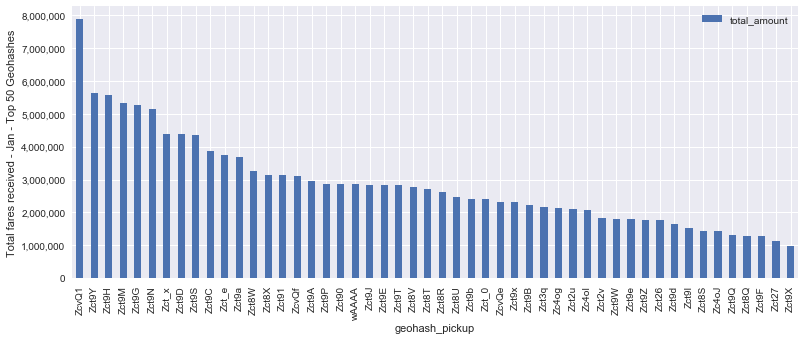

In [16]:
#plt.figure(figsize=(10,5))
ax = pickup_sum_fare[:50].plot(x='geohash_pickup',y='total_amount',kind='bar',figsize=(13,5))
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.ylabel('Total fares received - Jan - Top 50 Geohashes')

## Break up the day into ten minute intervals( the time to traverse a geohash of ~3803 meters).
### Note: This code is already run in the make_data.main() call in the first cell
- Aggregate all of the days together so that you have one 24 hour block
- For this 24 hour block, group by five minute periods
- For each period, take the geohash as the key and a list of tuples of ( average fares over the month, trip times in minutes)
- This gives an end result of the average fare and corresponding trip time and ration of fare/trip time for each geohash for a given ten minutes over each day in January

In [34]:

    
taxi_yellowcab_df['trip_time_minutes'] = taxi_yellowcab_df.trip_distance.apply(lambda x: convert_miles_to_minutes_nyc(x))

In [35]:
# distribution of trip times
trip_minutes_grouped = taxi_yellowcab_df.groupby('trip_time_minutes').count()

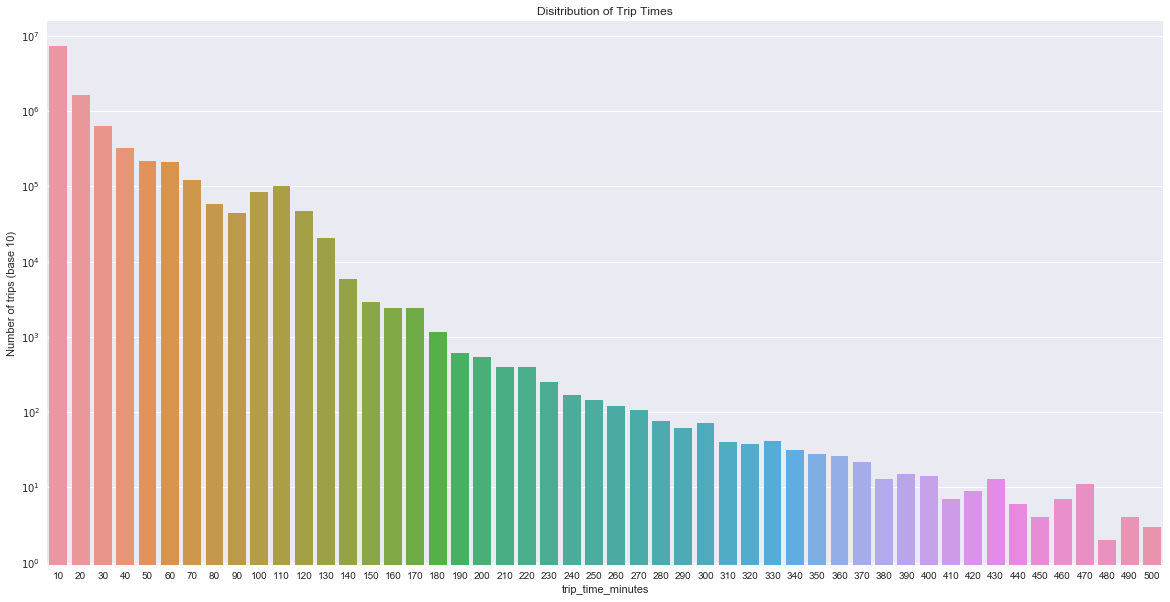

In [36]:
plt.figure(figsize=(20,10))
grid = sns.barplot(x = trip_minutes_grouped['VendorID'].reset_index()['trip_time_minutes'][:50],
            y= trip_minutes_grouped['VendorID'].reset_index()['VendorID'][:50])
grid.set( yscale="log")
plt.ylabel('Number of trips (base 10)')
plt.title('Disitribution of Trip Times')

## Index the geohashes to a number
#### List of possible times

In [17]:
## get a list of unique geohashes
list_of_unique_geohashes = taxi_yellowcab_df.geohash_pickup.unique()
len(list_of_unique_geohashes)

3086

In [18]:
list_of_geohash_index  = defaultdict(int)
for idx,hash_n in enumerate(list_of_unique_geohashes):
    list_of_geohash_index [hash_n] = idx

In [19]:
list_of_inverse_heohash_index = defaultdict(str)
for idx,hash_n in enumerate(list_of_unique_geohashes):
    list_of_inverse_heohash_index[idx] = hash_n

In [20]:
list_of_inverse_heohash_index

defaultdict(str,
            {0: 'Zct8X',
             1: 'Zct8c',
             2: 'Zct5T',
             3: 'Zct8Q',
             4: 'Zc4oK',
             5: 'Zct9J',
             6: 'Zc4oj',
             7: 'Zct8R',
             8: 'Zct3r',
             9: 'Zct9a',
             10: 'Zct8T',
             11: 'Zct3q',
             12: 'Zct8S',
             13: 'Zct9T',
             14: 'Zc4oM',
             15: 'Zct9W',
             16: 'Zct5w',
             17: 'Zct8W',
             18: 'Zct9B',
             19: 'Zct8V',
             20: 'Zct8P',
             21: 'Zct91',
             22: 'Zct9H',
             23: 'Zct9m',
             24: 'Zct8U',
             25: 'Zct9c',
             26: 'Zct8Y',
             27: 'Zct9e',
             28: 'wAAAA',
             29: 'Zc4oO',
             30: 'Zct6T',
             31: 'Zct9M',
             32: 'Zc4og',
             33: 'Zct5f',
             34: 'Zct9R',
             35: 'Zct8d',
             36: 'Zct9D',
             37: 'Zct9N',
     

In [21]:
hours = [str(_) for _ in range(24)]
minutes = [str(_) for _ in range(0,60,10)]
minutes.append('00')
list_of_time_index =[]
for h in hours:
    for m in minutes:

        list_of_time_index.append(int(str(h)+str(m)))
list_of_time_index = list(set(list_of_time_index))

In [22]:
list_of_time_index

[0,
 2050,
 1540,
 1030,
 520,
 10,
 1550,
 1040,
 530,
 20,
 1050,
 540,
 30,
 550,
 40,
 50,
 2100,
 60,
 2110,
 1600,
 70,
 2120,
 1610,
 1100,
 80,
 2130,
 1620,
 1110,
 600,
 90,
 2140,
 1630,
 1120,
 610,
 100,
 2150,
 1640,
 1130,
 620,
 110,
 1650,
 1140,
 630,
 120,
 1150,
 640,
 130,
 650,
 140,
 150,
 2200,
 160,
 2210,
 1700,
 170,
 2220,
 1710,
 1200,
 180,
 2230,
 1720,
 1210,
 700,
 190,
 2240,
 1730,
 1220,
 710,
 200,
 2250,
 1740,
 1230,
 720,
 210,
 1750,
 1240,
 730,
 220,
 1250,
 740,
 230,
 750,
 240,
 250,
 2300,
 2310,
 1800,
 2320,
 1810,
 1300,
 2330,
 1820,
 1310,
 800,
 2340,
 1830,
 1320,
 810,
 300,
 2350,
 1840,
 1330,
 820,
 310,
 1850,
 1340,
 830,
 320,
 1350,
 840,
 330,
 850,
 340,
 350,
 1900,
 1910,
 1400,
 1920,
 1410,
 900,
 1930,
 1420,
 910,
 400,
 1940,
 1430,
 920,
 410,
 1950,
 1440,
 930,
 420,
 1450,
 940,
 430,
 950,
 440,
 450,
 2000,
 2010,
 1500,
 2020,
 1510,
 1000,
 2030,
 1520,
 1010,
 500,
 2040,
 1530,
 1020,
 510]

In [23]:
taxi_yellowcab_df.columns

Index(['Unnamed: 0', 'VendorID', 'tpep_pickup_datetime',
       'tpep_dropoff_datetime', 'passenger_count', 'trip_distance',
       'pickup_longitude', 'pickup_latitude', 'RatecodeID',
       'store_and_fwd_flag', 'dropoff_longitude', 'dropoff_latitude',
       'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'total_amount',
       'geohash_pickup', 'geohas_dropoff', 'jan_day', 'jan_minute',
       'geohash_dropoff', 'trip_time_minutes'],
      dtype='object')

# Use an Actor Critic Model
- https://yanpanlau.github.io/2016/10/11/Torcs-Keras.html

In [75]:
def create_actor_network(self, state_size,action_dim):
        print("Now we build the model")
        S = Input(shape=[state_size])  
        h0 = Dense(HIDDEN1_UNITS, activation='relu')(S)
        h1 = Dense(HIDDEN2_UNITS, activation='relu')(h0)
        Steering = Dense(1,activation='tanh',init=lambda shape, name: normal(shape, scale=1e-4, name=name))(h1)   
        Acceleration = Dense(1,activation='sigmoid',init=lambda shape, name: normal(shape, scale=1e-4, name=name))(h1)   
        Brake = Dense(1,activation='sigmoid',init=lambda shape, name: normal(shape, scale=1e-4, name=name))(h1)   
        V = merge([Steering,Acceleration,Brake],mode='concat')          
        model = Model(input=S,output=V)
        print("We finished building the model")
        return model, model.trainable_weights, S

# MLP model architecture - DQN

In [40]:
##Define a simple model where the output is a softmax probability over the eight states
# Inputs will be the time, current geohash-index ()
# Outputs are nine numbers which correspond to a direction to go in
# 0) NW 1) N                     2) NE
# 3) W  4) Stay in same geohash  5)E
# 6)SW  7) S                    8) SE
model_mlp = Sequential()
model_mlp.add(Dense(100, input_shape=(2,)))
model_mlp.add(BatchNormalization())
model_mlp.add(Activation('relu'))
model_mlp.add(Dropout(.3))
model_mlp.add(Dense(500))
model_mlp.add(BatchNormalization())
model_mlp.add(Activation('relu'))
model_mlp.add(Dropout(.3))
model_mlp.add(Dense(1000))
model_mlp.add(BatchNormalization())
model_mlp.add(Activation('relu'))
model_mlp.add(Dropout(.3))
model_mlp.add(Dense(9, activation='linear')) ## predict which geohash to move to next
adam = Adam(lr=.1)
model_mlp.compile(loss='mse',optimizer=adam)
model_mlp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 100)               300       
_________________________________________________________________
batch_normalization_22 (Batc (None, 100)               400       
_________________________________________________________________
activation_22 (Activation)   (None, 100)               0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 500)               50500     
_________________________________________________________________
batch_normalization_23 (Batc (None, 500)               2000      
_________________________________________________________________
activation_23 (Activation)   (None, 500)               0         
__________

# LSTM model architecture - DQN


In [174]:
sample_size = 5000
batch_sizze = 32

In [186]:
#(sequences, timesteps, dimensions). 
model_lstm = Sequential()
model_lstm .add(LSTM(100, dropout=0.4,batch_input_shape=(1,sample_size,2),
                     recurrent_dropout=0.5,return_sequences =True))
model_lstm .add(LSTM(100, dropout=0.4,
                     recurrent_dropout=0.5, return_sequences = True))
model_lstm .add(LSTM(100, dropout=0.4,
                     recurrent_dropout=0.5,return_sequences = True))
model_lstm.add(Dense(100, activation='relu'))
model_lstm .add(Dense(9, activation='linear'))
model_lstm .compile(loss='mean_squared_error', optimizer='adam')
model_lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_51 (LSTM)               (1, 5000, 100)            41200     
_________________________________________________________________
lstm_52 (LSTM)               (1, 5000, 100)            80400     
_________________________________________________________________
lstm_53 (LSTM)               (1, 5000, 100)            80400     
_________________________________________________________________
dense_78 (Dense)             (1, 5000, 100)            10100     
_________________________________________________________________
dense_79 (Dense)             (1, 5000, 9)              909       
Total params: 213,009.0
Trainable params: 213,009
Non-trainable params: 0.0
_________________________________________________________________


In [382]:
x = np.load("../src/models-DQN/training_x.npy")
#x = x.reshape(1,50001,2)
#x = x[: , :5000 , :]
y = np.load("../src/models-DQN/training_y.npy")
#y = y.reshape(1, 50001, 9 )
#y = y[:, :5000, :]

In [383]:
y.shape

(15000, 9)

In [384]:
x.shape

(15000, 2)

In [323]:
#x= np.delete(x, np.array([68,2525,11927,16094,21553,24015,25747,34193,39398,43567,48340,48781,16988,16987]), axis=0)

In [322]:
#y= np.delete(y, np.array([68,2525,11927,16094,21553,24015,25747,34193,39398,43567,48340,48781,16988,16987]), axis=0)

In [329]:
np.save("../src/models-DQN/training_x.npy",x[:15000])
np.save("../src/models-DQN/training_y.npy",y[:15000])

In [385]:

for idx,i in enumerate(y):
    if np.all(i==0):
        print(i)
        print(idx,'row')
    else:
        pass
    

In [337]:
y = y[:,:10000,:]#

In [352]:
y = y.reshape(1,15000,9)

In [353]:
test,train = np.split(y,2,axis=1)

In [346]:
test.shape

(7500, 9)

In [347]:
train.shape

(7500, 9)

In [ ]:
model_simple.train_on_batch()

In [20]:
model_simple.predict(X)

array([[  9.99218583e-01,   3.69379142e-13,   1.08317809e-22,
          5.93804972e-21,   4.04363523e-16,   6.70722822e-25,
          9.62229051e-26,   3.95748365e-12,   7.81367882e-04]], dtype=float32)

In [21]:
list_of_geohash_index[np.random.choice(list_of_unique_geohashes)] # index of geohash

37

In [259]:
np.random.choice(list_of_time_index) # time

1410

In [271]:
np.array([[np.random.choice(list_of_time_index),
                     list_of_geohash_index[np.random.choice(list_of_unique_geohashes)]]])
    

array([[ 605, 2775]])

In [278]:
random.randrange(ACTIONS)

8

# Show that the model can overfit a small training set
#### DQN and MLP
--- Assume that all trips are ten minutes

In [363]:
starting_geohash = 'Zc4o0'
geohash_index_1 = list_of_geohash_index['Zc4o-']
starting_time = 110

In [ ]:
# time, geohash for predictions

{'e': 'Zc4o2',
 'n': 'Zc4o1',
 'ne': 'Zc4o3',
 'nw': 'Zc4of',
 's': 'Zc4ox',
 'se': 'Zc4oz',
 'sw': 'Zc4ob',
 'w': 'Zc4oe'}

In [273]:
gh.neighbors('Zc4o0')

{'e': 'Zc4o2',
 'n': 'Zc4o1',
 'ne': 'Zc4o3',
 'nw': 'Zc4of',
 's': 'Zc4ox',
 'se': 'Zc4oz',
 'sw': 'Zc4ob',
 'w': 'Zc4oe'}

In [355]:
# options to move to
nw_1 = final_data_structure[110]['Zc4of']
n_1 =  final_data_structure[110]['Zc4o1']
ne_1 = final_data_structure[110]['Zc4o3']
w_1 = final_data_structure[110]['Zc4oe']
stay_1 = final_data_structure[110][starting_geohash]
e_1 = final_data_structure[110]['Zc4o2']
sw_1 = final_data_structure[110]['Zc4ob']
s_1 = final_data_structure[110]['Zc4ox']
se_1 = final_data_structure[110]['Zc4oz']


In [358]:
## find the best ratio of fare / time traveled
max_nw_1 = 0
max_n_1 = max(n_1,key=itemgetter(2))[2]
max_ne_1 =max(ne_1,key=itemgetter(2))[2]
max_w_1 = max(w_1,key=itemgetter(2))[2]
max_stay_1 = max(stay_1,key=itemgetter(2))[2]
max_e_1 = max(e_1,key=itemgetter(2))[2]
max_sw_1 = max(sw_1,key=itemgetter(2))[2]
max_s_1 = max(s_1,key=itemgetter(2))[2]
max_se_1 = max(se_1,key=itemgetter(2))[2]

In [359]:
## Find the optimal move
np.argmax(np.array([max_n_1,max_ne_1,max_w_1,max_stay_1,max_e_1,max_sw_1,max_s_1,max_se_1]))

0

In [360]:
max_n_1

2.679999999732

In [388]:
### optimal move is to go North
# First training point, time followed by geohash
first_x = np.array([[110,geohash_index_1]])
first_y = np.array([[0,1,0,0,0,0,0,0,0]])

In [370]:
### Next time step
## geohash two
geohash_2 = 'Zc4o1'
geohash_index_2 = list_of_geohash_index['Zc4o1']
time_2 = 120

In [371]:
## find potential moves
gh.neighbors('Zc4o1')

{'e': 'Zc4o3',
 'n': 'Zc4pg',
 'ne': 'Zc4pi',
 'nw': 'Zc4pK',
 's': 'Zc4o0',
 'se': 'Zc4o2',
 'sw': 'Zc4oe',
 'w': 'Zc4of'}

In [376]:
# options to move to
nw_2 = final_data_structure[120]['Zc4pK']
n_2 =  final_data_structure[120]['Zc4pg']
ne_2 = final_data_structure[120]['Zc4pi']
w_2 = final_data_structure[120]['Zc4of']
stay_2 = final_data_structure[120][geohash_2]
e_2 = final_data_structure[120]['Zc4o3']
sw_2 = final_data_structure[120]['Zc4oe']
s_2 = final_data_structure[120]['Zc4o0']
se_2 = final_data_structure[120]['Zc4o2']


In [386]:
## find the best ratio of fare / time traveled, zeros indicate no fare data available 
max_nw_2 = 0
max_n_2 = max(n_2,key=itemgetter(2))[2]
max_ne_2 =max(ne_2,key=itemgetter(2))[2]
max_w_2 = 0
max_stay_2 = max(stay_2,key=itemgetter(2))[2]
max_e_2 = max(e_2,key=itemgetter(2))[2]
max_sw_2 = max(sw_2,key=itemgetter(2))[2]
max_s_2 = max(s_2,key=itemgetter(2))[2]
max_se_2 = max(se_2,key=itemgetter(2))[2]

In [387]:
## Find the optimal move
np.argmax(np.array([0,max_n_2,max_ne_2,0,max_stay_2,max_e_2,max_sw_2,max_s_2,max_se_2]))

8

In [389]:
# best move is to go SE!
second_x = np.array([[120,geohash_index_2]])
second_y = np.array([[0,0,0,0,0,0,0,0,1]])

In [390]:
### Next time step
## geohash three
geohash_3 = 'Zc4o2'
geohash_index_3 = list_of_geohash_index['Zc4o2']
time_3 = 130

In [391]:
## find potential moves
gh.neighbors('Zc4o2')

{'e': 'Zc4o8',
 'n': 'Zc4o3',
 'ne': 'Zc4o9',
 'nw': 'Zc4o1',
 's': 'Zc4oz',
 'se': 'Zc4o5',
 'sw': 'Zc4ox',
 'w': 'Zc4o0'}

In [ ]:
# options to move to
nw_3 = final_data_structure[130]['Zc4pK']
n_3 =  final_data_structure[130]['Zc4pg']
ne_3 = final_data_structure[130]['Zc4pi']
w_3 = final_data_structure[130]['Zc4of']
stay_3 = final_data_structure[130][geohash_2]
e_3 = final_data_structure[130]['Zc4o3']
sw_3 = final_data_structure[130]['Zc4oe']
s_3 = final_data_structure[130]['Zc4o0']
se_3 = final_data_structure[130]['Zc4o2']


# Hyperas results for MLP model

```python
model_mlp = Sequential()
model_mlp.add(Dense({{choice([32, 64,126, 256, 512, 1024])}},
                        activation='relu', input_shape= (2,)))
model_mlp.add(Dropout({{uniform(0, .5)}}))
model_mlp.add(Dense({{choice([32, 64, 126, 256, 512, 1024])}}))
model_mlp.add(Activation({{choice(['relu', 'sigmoid'])}}))
model_mlp.add(Dropout({{uniform(0, .5)}}))
model_mlp.add(Dense({{choice([32, 64, 126, 256, 512, 1024])}}))
model_mlp.add(Activation({{choice(['relu', 'sigmoid'])}}))
model_mlp.add(Dropout({{uniform(0, .5)}}))
model_mlp.add(Dense({{choice([32, 64, 126, 256, 512, 1024])}}))
model_mlp.add(Activation({{choice(['relu', 'sigmoid'])}}))
model_mlp.add(Dropout({{uniform(0, .5)}}))
model_mlp.add(Dense(9))
model_mlp.add(Activation({{choice(['softmax','linear'])}}))
model_mlp.compile(loss={{choice(['categorical_crossentropy','mse'])}}, metrics=['accuracy'],
                  optimizer={{choice(['rmsprop', 'adam', 'sgd'])}})```



> model_mlp.fit(x_train, y_train,
              batch_size={{choice([16, 32, 64, 128])}},
              epochs=50,
              verbose=2,
              validation_data=(x_test, y_test))
    score, acc = model_mlp.evaluate(x_test, y_test, verbose=0)





>Best performing model chosen hyper-parameters:
- {'Activation': 1, 'Activation_1': 0, 'Activation_2': 0, 'Activation_3': 0, 'Dense': 0, 'Dense_1': 1, 'Dense_2': 1, 'Dense_3': 5, 'Dropout': 0.056229870832780804, 'Dropout_1': 0.1603763880022983, 'Dropout_2': 0.3671073489296299, 'Dropout_3': 0.3462695171578595, 'batch_size': 0, 'loss': 1, 'optimizer': 2}
- Interesting, use MSE with softmax

# Hyperas results for LSTM model

```python 
model_lstm = Sequential()
model_lstm .add(LSTM({{choice([64, 126, 256, 512, 1024])}}, dropout={{uniform(0, .5)}},
                     batch_input_shape=(1,x_train.shape[1], 2),
                 recurrent_dropout={{uniform(0, .5)}},return_sequences = True))
model_lstm.add(BatchNormalization())
condition = conditional({{choice(['one','two','three', 'four'])}})

if condition == 'one':
    pass
elif condition == 'two':
    model_lstm .add(LSTM({{choice([64, 126, 256, 512, 1024])}}, dropout={{uniform(0, .5)}},
                 recurrent_dropout={{uniform(0, .5)}},
                 return_sequences = True))
    model_lstm.add(BatchNormalization())
elif condition  == 'three':
    model_lstm .add(LSTM({{choice([64, 126, 256, 512, 1024])}}, dropout={{uniform(0, .5)}},
                 recurrent_dropout={{uniform(0, .5)}},
                 return_sequences = True))
    model_lstm.add(BatchNormalization())
    model_lstm.add(Dense({{choice([126, 256, 512, 1024])}}))
    model_lstm.add(BatchNormalization())
    model_lstm.add(Activation({{choice(['relu','tanh','sigmoid'])}}))
elif condition == 'four':
    model_lstm .add(LSTM({{choice([64, 126, 256, 512, 1024])}}, dropout={{uniform(0, .5)}},
                 recurrent_dropout={{uniform(0, .5)}},
                 return_sequences = True))
    model_lstm.add(BatchNormalization())
    model_lstm.add(Dense({{choice([126, 256, 512, 1024])}}))
    model_lstm.add(BatchNormalization())
    model_lstm.add(Activation({{choice(['relu','tanh','sigmoid'])}}))
    model_lstm.add(Dense({{choice([126, 256, 512, 1024])}}, activation='relu'))
    model_lstm.add(BatchNormalization())
    model_lstm.add(Activation({{choice(['relu','tanh','sigmoid'])}}))


model_lstm .add(Dense(9, activation='linear',name='dense_output'))
adam = Adam(clipnorm=.5, clipvalue=.5)
model_lstm .compile(loss='mean_squared_error', optimizer=adam,
                    metrics=['accuracy'])
model_lstm.summary()



```

- Results



- {'Activation': 2, 'Activation_1': 2, 'Activation_2': 0, 
- 'Dense': 2, 'Dense_1': 2, 'Dense_2': 0,
- 'LSTM': 3, 'LSTM_1': 0, 'LSTM_2': 4, 'LSTM_3': 1, 
- 'conditional': 2, 
- 'dropout': 0.24262496679483414, 'dropout_1': 0.24083776969398046, 'dropout_2': 0.4440995372232807, 'dropout_3': 0.19378913952416787, 'dropout_4': 0.18058579914657197, 'dropout_5': 0.1820122957634046, 'dropout_6': 0.11399536937803484, 'dropout_7': 0.13709791545993666}
- Three layers performed best



# GPU vs CPU

In [17]:
gpu_speed_1k = 55
cpu_speed_1k = 59


In [19]:
# How much time is saved over 1,000,000 training examples?
print('We save about {} minutes over 1 million training iterations'.format(round((1000000/1000 * \
                                                                                     (cpu_speed_1k -gpu_speed_1k ))/60)))

We save about 67 minutes over 1 million training iterations


# DQN approach

### Investigate the loss over time

In [54]:
with open(r"mlp_model/loss_over_time_linear", "rb") as input_file:
     loss_over_time_mlp = pickle.load(input_file)



In [56]:
len(loss_over_time_mlp)

995000

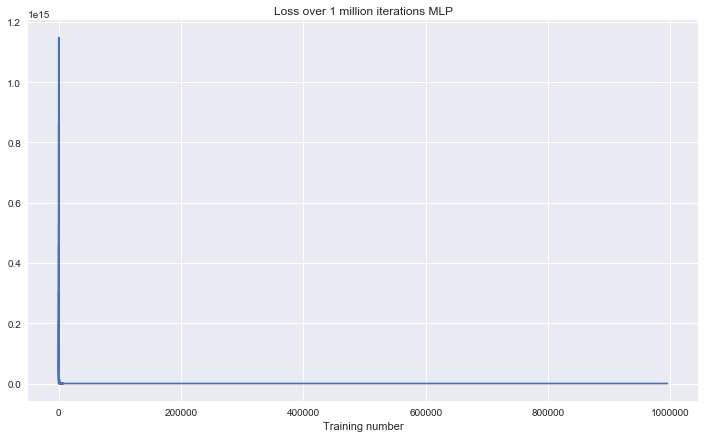

In [60]:
plt.figure(figsize=(12,7))
plt.plot(loss_over_time_mlp)
plt.title('Loss over 1 million iterations MLP')
plt.xlabel('Training number')

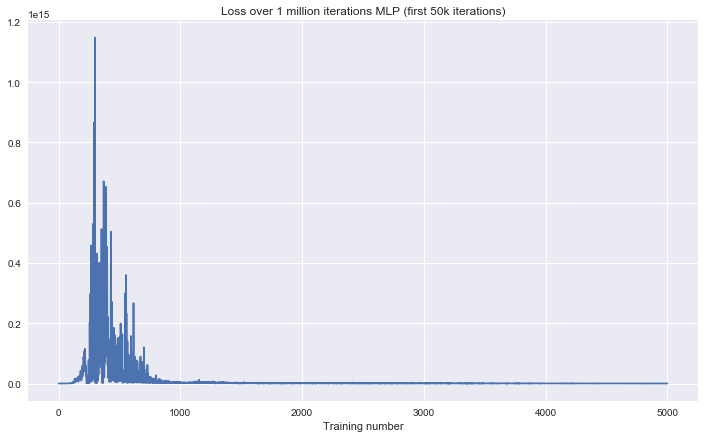

In [64]:
plt.figure(figsize=(12,7))
plt.plot(loss_over_time_mlp[:5000])
plt.title('Loss over 1 million iterations MLP (first 50k iterations)')
plt.xlabel('Training number')

## Investigate the fare earned in a naive approach vs 1 million training iterations

In [262]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
total_fare_received_over_time_no_train = total_fare_received_over_time
naive_fare_over_time_no_train = naive_fare_over_time

### No training, fares between RL and naive

In [ ]:
train_rl_taxi = RLNYCTaxiCab(list_of_unique_geohashes,list_of_time_index,list_of_geohash_index,
                            list_of_inverse_heohash_index, final_data_structure, return_metrics=True)
arg = {'mode':'Test','save_model':False,'model_weights_load':'model_mlp.h5',
               'save_model_weights':'mlp_linear.h5'}# for the million parameter weights
loss_list, total_fare_received_over_time_no_train,list_of_geohashes_visited, \
naive_fare_over_time_no_train, days_driven, naive_geohashes =\
    train_rl_taxi.trainNetworkNeuralNetworkTaxicab(arg, training_length=3000, return_training_data = False)

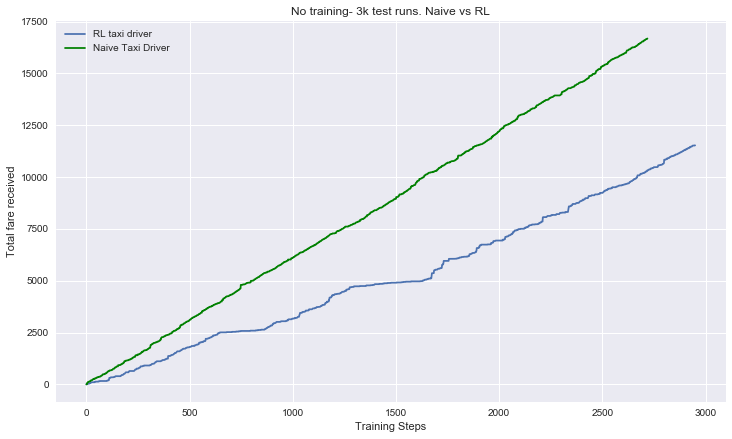

In [62]:
plt.figure(figsize=(12,7))
plt.plot(total_fare_received_over_time_no_train, label = 'RL taxi driver')
plt.plot(naive_fare_over_time_no_train, color='green',label='Naive Taxi Driver')
plt.legend()
plt.title('No training- 3k test runs. Naive vs RL')
plt.ylabel('Total fare received')
plt.xlabel('Training Steps')

## One million training iterations, fares between RL and Naive

In [250]:

    
train_rl_taxi = RLNYCTaxiCab(list_of_unique_geohashes,list_of_time_index,list_of_geohash_index,
                            list_of_inverse_heohash_index, final_data_structure, return_metrics=True)
arg = {'mode':'Run','model_weights_load':'mlp_model/model_mlp_linear_onemillion.h5',
      'save_model_weights':'mlp_linear_1million.h5'} # for the million parameter weights

loss_list, total_fare_received_over_time_onemillion_training,list_of_geohashes_visited, \
naive_fare_over_time_onemillion_training, days_driven, naive_geohashes =\
    train_rl_taxi.trainNetworkNeuralNetworkTaxicab(arg, training_length=3000, return_training_data = False)

Now we load weight
Weight load successfully
TIMESTEP 0 / STATE observe / EPSILON 0.0001 / ACTION 3 / REWARD -0.1 / Q_MAX  0 / Loss  0 / Total fare RL  0 / Total fare naive 0
500 steps took 4.892161130905151
We finished a day!
We finished a day!
We finished a day!
We finished a day!
We finished a day!
We finished a day!
TIMESTEP 500 / STATE observe / EPSILON 0.0001 / ACTION 3 / REWARD 1.29481481469 / Q_MAX  0 / Loss  0 / Total fare RL  0 / Total fare naive 0
500 steps took 2.8019661903381348
We finished a day!
We finished a day!
We finished a day!


KeyboardInterrupt: 

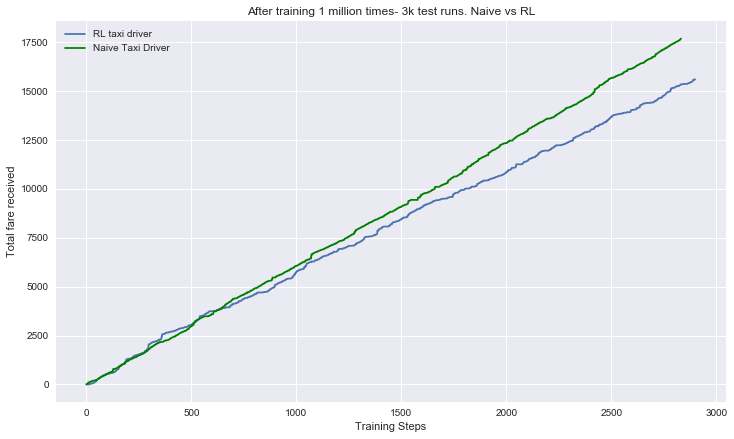

In [89]:
plt.figure(figsize=(12,7))
plt.plot(total_fare_received_over_time_onemillion_training, label = 'RL taxi driver')
plt.plot(naive_fare_over_time_onemillion_training, color='green',label='Naive Taxi Driver')
plt.legend()
plt.title('After training 1 million times- 3k test runs. Naive vs RL')
plt.ylabel('Total fare received')
plt.xlabel('Training Steps')

### 1.5 million training iterations, fares between rl and naive, DQN MLP

In [35]:
train_rl_taxi = RLNYCTaxiCab(list_of_unique_geohashes,list_of_time_index,list_of_geohash_index,
                            list_of_inverse_heohash_index, final_data_structure, return_metrics=True)
arg = {'mode':'Run','model_weights_load':'mlp_model/model_mlp_linear_1.5million.h5',
      'save_model_weights':'mlp_linear_1.5million.h5'} # for the million parameter weights


loss_list_1_5million, total_fare_received_over_time_1_5million_training,list_of_geohashes_visited_1_5million, \
naive_fare_over_time_1_5million_training, days_driven1_5million, naive_geohashes_1_5million =\
    train_rl_taxi.trainNetworkNeuralNetworkTaxicab(arg, training_length=3000, return_training_data = False)

Now we load weight
Weight load successfully
TIMESTEP 0 / STATE observe / EPSILON 0.0001 / ACTION 8 / REWARD -0.1 / Q_MAX  0 / Loss  0 / Total fare RL  0 / Total fare naive 0
500 steps took 0.442213773727417
We finished a day!
We finished a day!
We finished a day!
We finished a day!
We finished a day!
TIMESTEP 500 / STATE explore / EPSILON 0.0001 / ACTION 6 / REWARD 0.977999999951 / Q_MAX  30.6298 / Loss  0.0234769843519 / Total fare RL  2263.40475892 / Total fare naive 3212.80827072
500 steps took 80.66987490653992
We finished a day!
We finished a day!
We finished a day!
We finished a day!
We finished a day!
TIMESTEP 1000 / STATE explore / EPSILON 0.0001 / ACTION 8 / REWARD 1.11499999994 / Q_MAX  33.7408 / Loss  3.82280755043 / Total fare RL  5462.41590721 / Total fare naive 5684.45654461
500 steps took 91.17907524108887
We finished a day!
We finished a day!
We finished a day!
We finished a day!
We finished a day!
We finished a day!
TIMESTEP 1500 / STATE explore / EPSILON 0.0001 / ACTI

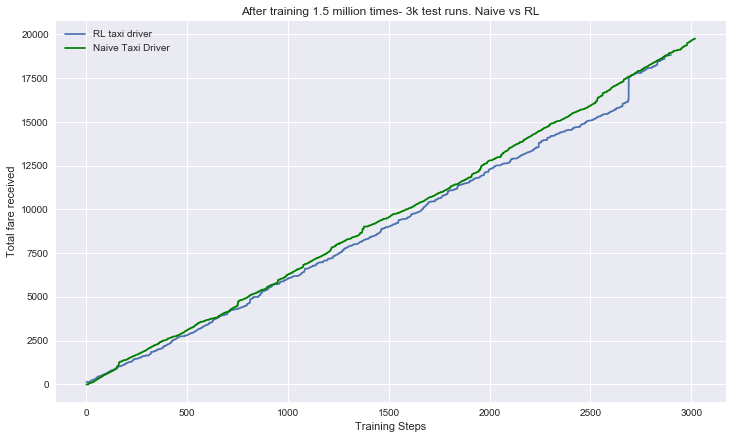

In [36]:
plt.figure(figsize=(12,7))
plt.plot(total_fare_received_over_time_1_5million_training, label = 'RL taxi driver')
plt.plot(naive_fare_over_time_1_5million_training, color='green',label='Naive Taxi Driver')
plt.legend()
plt.title('After training 1.5 million times- 3k test runs. Naive vs RL')
plt.ylabel('Total fare received')
plt.xlabel('Training Steps')

# Two million training examples - MLP DQN

In [263]:
train_rl_taxi = RLNYCTaxiCab(list_of_unique_geohashes,list_of_time_index,list_of_geohash_index,
                            list_of_inverse_heohash_index, final_data_structure, return_metrics=True)
arg = {'mode':'Run','model_weights_load':'mlp_model/model_mlp_linear_2million.h5',
      'save_model_weights':'mlp_linear_2million.h5'} # for the million parameter weights


loss_list_2million, total_fare_received_over_time_2million_training,list_of_geohashes_visited_2million, \
naive_fare_over_time_2million_training, days_driven2million, naive_geohashes_2million =\
    train_rl_taxi.trainNetworkNeuralNetworkTaxicab(arg, training_length=3000, return_training_data = False, 
                                                   save_model = False)

Now we load weight
Weight load successfully
Now we save model
TIMESTEP 0 / STATE observe / EPSILON 0.0001 / ACTION 7 / REWARD -0.1 / Q_MAX  0 / Loss  0 / Total fare RL  0 / Total fare naive 0
500 steps took 37.30184078216553
We finished a day!
We finished a day!
We finished a day!
We finished a day!
We finished a day!
We finished a day!
TIMESTEP 500 / STATE observe / EPSILON 0.0001 / ACTION 7 / REWARD -0.1 / Q_MAX  0 / Loss  0 / Total fare RL  0 / Total fare naive 0
500 steps took 8.266385316848755
We finished a day!
We finished a day!
We finished a day!
We finished a day!
We finished a day!
Now we save model
TIMESTEP 1000 / STATE explore / EPSILON 0.0001 / ACTION 0 / REWARD -0.1 / Q_MAX  31.9134 / Loss  0.0412013083696 / Total fare RL  3065.8938011 / Total fare naive 3337.90947413
500 steps took 342.94936180114746
We finished a day!
We finished a day!
We finished a day!
TIMESTEP 1500 / STATE explore / EPSILON 0.0001 / ACTION 3 / REWARD 0.655857142824 / Q_MAX  33.4584 / Loss  0.1884469

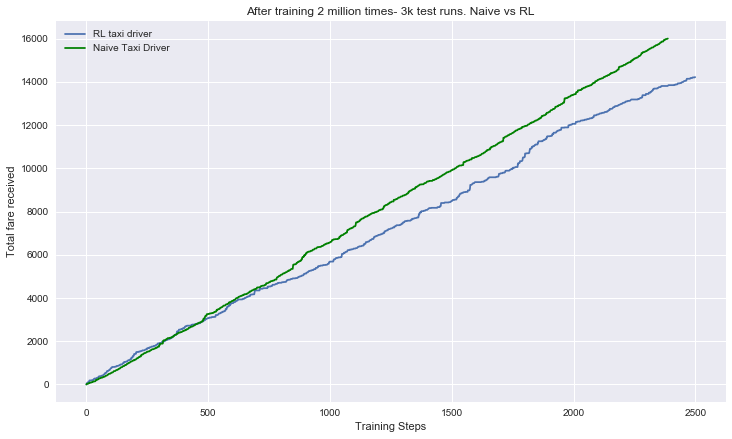

In [264]:
plt.figure(figsize=(12,7))
plt.plot(total_fare_received_over_time_2million_training, label = 'RL taxi driver')
plt.plot(naive_fare_over_time_2million_training, color='green',label='Naive Taxi Driver')
plt.legend()
plt.title('After training 2 million times- 3k test runs. Naive vs RL')
plt.ylabel('Total fare received')
plt.xlabel('Training Steps')

In [193]:
print("With two million training examples, we can expect to make this much more {:%} per day.".format(
    (10369.2298465-10024.9831939)/10024.9831939))


With two million training examples, we can expect to make this much more 3.433888% per day.


# Total fare received over one million training examples

In [72]:
with open(r"mlp_model/rl_total_fare_time_linear", "rb") as input_file:
     rl_total_fare_time_linear = pickle.load(input_file)

In [73]:
with open(r"mlp_model/naive_fare_time_linear", "rb") as input_file:
     naive_fare_time_linear = pickle.load(input_file)

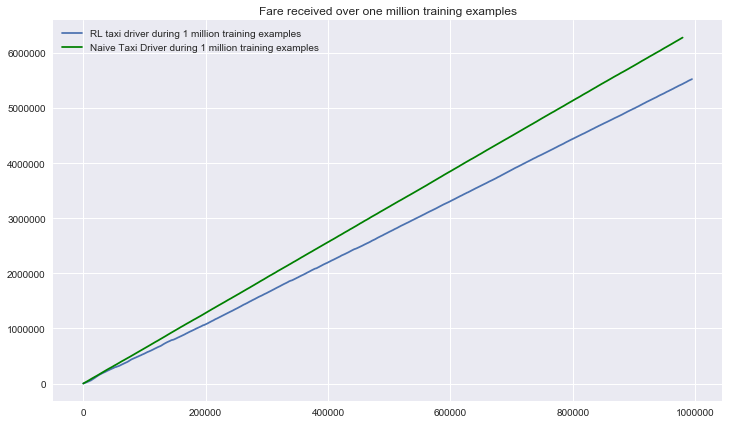

In [76]:
plt.figure(figsize=(12,7))
plt.plot(rl_total_fare_time_linear , label = 'RL taxi driver during 1 million training examples')
plt.plot(naive_fare_time_linear, color='green',label='Naive Taxi Driver during 1 million training examples')
plt.legend()
plt.title('Fare received over one million training examples')

In [68]:
%load_ext autoreload
%autoreload 2


# Visualize the path taken - Two million training examples, 3k test

In [244]:
decoded_rl = [gh.decode(i) for i in list_of_geohashes_visited_2million if type(i)!=int]
print('RL path taken')
list_of_rl_path = defaultdict(int)
for line in decoded_rl:
    list_of_rl_path[str(line['lat'])+',',line['lon']]+=1
for k,v in list_of_rl_path.items():
    print('rl',',','rl',',',k[0],k[1],",",v)

RL path taken
rl , rl , 40.696105, -73.954467 , 2
rl , rl , 40.690612, -73.954467 , 4
rl , rl , 40.685119, -73.954467 , 2
rl , rl , 40.679626, -73.954467 , 2
rl , rl , 40.674133, -73.954467 , 3
rl , rl , 40.66864, -73.954467 , 3
rl , rl , 40.663146, -73.954467 , 2
rl , rl , 40.657653, -73.954467 , 1
rl , rl , 40.65216, -73.954467 , 1
rl , rl , 40.646667, -73.954467 , 1
rl , rl , 40.641174, -73.954467 , 1
rl , rl , 40.635681, -73.954467 , 2
rl , rl , 40.630187, -73.954467 , 1
rl , rl , 40.624694, -73.954467 , 1
rl , rl , 40.619201, -73.954467 , 1
rl , rl , 40.613708, -73.954467 , 1
rl , rl , 40.608215, -73.954467 , 1
rl , rl , 40.602722, -73.954467 , 1
rl , rl , 40.597229, -73.954467 , 1
rl , rl , 40.591735, -73.954467 , 1
rl , rl , 40.586242, -73.954467 , 1
rl , rl , 40.580749, -73.954467 , 1
rl , rl , 40.575256, -73.954467 , 1
rl , rl , 40.569763, -73.954467 , 1
rl , rl , 40.729064, -73.987426 , 58
rl , rl , 40.723571, -73.987426 , 55
rl , rl , 40.718078, -73.987426 , 52
rl , rl , 40.

In [261]:
decoded_naive = [gh.decode(i) for i in naive_geohashes_2million if type(i)!=int]
print('Naive path taken')
list_of_naive_path = defaultdict(int)
for line in decoded_naive:
    list_of_naive_path[str(line['lat'])+',',line['lon']]+=1
for k,v in list_of_naive_path.items():
    print('naive',',','naive',',',k[0],k[1],",",v)

Naive path taken
naive , naive , 40.740051, -73.97644 , 80
naive , naive , 40.844421, -73.833618 , 1
naive , naive , 40.844421, -73.844604 , 1
naive , naive , 40.838928, -73.844604 , 1
naive , naive , 40.833435, -73.85559 , 1
naive , naive , 40.729064, -73.998413 , 82
naive , naive , 40.723571, -73.987426 , 39
naive , naive , 40.718078, -73.987426 , 18
naive , naive , 40.712585, -73.97644 , 9
naive , naive , 40.745544, -73.97644 , 41
naive , naive , 40.745544, -73.965454 , 38
naive , naive , 40.740051, -73.965454 , 51
naive , naive , 40.729064, -73.987426 , 90
naive , naive , 40.734558, -73.987426 , 56
naive , naive , 40.734558, -73.965454 , 53
naive , naive , 40.740051, -73.954467 , 33
naive , naive , 40.734558, -73.97644 , 83
naive , naive , 40.745544, -73.987426 , 57
naive , naive , 40.740051, -73.998413 , 74
naive , naive , 40.751037, -73.97644 , 17
naive , naive , 40.745544, -73.954467 , 29
naive , naive , 40.740051, -73.943481 , 21
naive , naive , 40.745544, -73.932495 , 10
naive

## Loss after 600k iterations


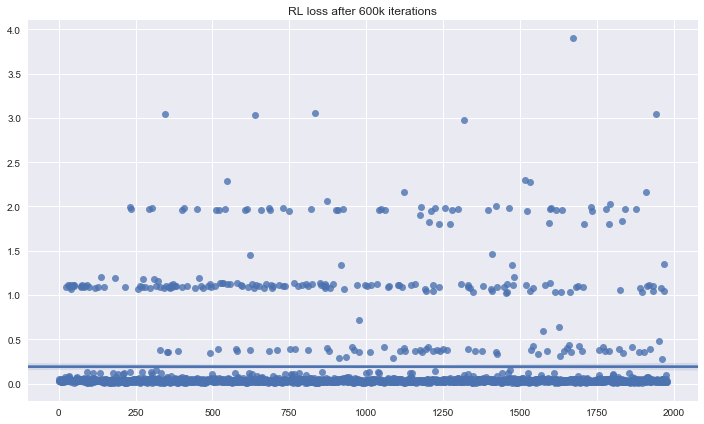

In [136]:
plt.figure(figsize=(12,7))
sns.regplot(np.array([_ for _ in range(len(loss_list))]),np.array(loss_list))  # 50 k
plt.title('RL loss after 600k iterations')

# Deep Deterministic Policy Gradient

In [231]:
import numpy as np
import math

from keras.models import model_from_json
from keras.models import Sequential, Model
#from keras.engine.training import collect_trainable_weights
from keras.layers import Dense, Flatten, Input, merge, Lambda
from keras.optimizers import Adam
import tensorflow as tf
import keras.backend as K

HIDDEN1_UNITS = 300
HIDDEN2_UNITS = 600

class ActorNetwork(object):
    def __init__(self, sess, state_size, action_size, BATCH_SIZE, TAU, LEARNING_RATE):
        self.sess = sess
        self.BATCH_SIZE = BATCH_SIZE
        self.TAU = TAU
        self.LEARNING_RATE = LEARNING_RATE

        K.set_session(sess)

        #Now create the model
        self.model , self.weights, self.state = self.create_actor_network(state_size, action_size)   
        self.target_model, self.target_weights, self.target_state = self.create_actor_network(state_size, action_size) 
        self.action_gradient = tf.placeholder(tf.float32,[None, action_size])
        self.params_grad = tf.gradients(self.model.output, self.weights, -self.action_gradient)
        grads = zip(self.params_grad, self.weights)
        self.optimize = tf.train.AdamOptimizer(LEARNING_RATE).apply_gradients(grads)
        self.sess.run(tf.global_variables_initializer())

    def train(self, states, action_grads):
        self.sess.run(self.optimize, feed_dict={
            self.state: states,
            self.action_gradient: action_grads
        })

    def target_train(self):
        actor_weights = self.model.get_weights()
        actor_target_weights = self.target_model.get_weights()
        for i in xrange(len(actor_weights)):
            actor_target_weights[i] = self.TAU * actor_weights[i] + (1 - self.TAU)* actor_target_weights[i]
        self.target_model.set_weights(actor_target_weights)

    def create_actor_network(self, state_size,action_dim):
        print("Now we build the model")
        S = Input(shape=[state_size])
        
        ddpg_mlp_actor = Sequential()
        ddpg_mlp_actor.add(InputLayer(input_tensor = S, input_shape(state_size,)))
        ddpg_mlp_actor.add(Dense(HIDDEN1_UNITS))
        ddpg_mlp_actor.add(BatchNormalization())
        ddpg_mlp_actor.add(Activation('relu'))
        ddpg_mlp_actor.add(Dense(HIDDEN2_UNITS))
        ddpg_mlp_actor.add(BatchNormalization())
        ddpg_mlp_actor.add(Activation('relu'))
        ddpg_mlp_actor.add(Dense(9, activation='linear'))
        
#         model = Sequential()
#         model.add(InputLayer(input_tensor=custom_input_tensor,
#                      input_shape=(None, 784)))
         
        print(S, ' S state size')
        #print( ddpg_mlp_actor.trainable_weights,'trainable weights')
        return ddpg_mlp_actor, ddpg_mlp_actor.trainable_weights, S

SyntaxError: positional argument follows keyword argument (<ipython-input-231-1d46d8e7205e>, line 51)

In [ ]:
import numpy as np
import math
from keras.initializations import normal, identity
from keras.models import model_from_json, load_model
from keras.engine.training import collect_trainable_weights
from keras.models import Sequential
from keras.layers import Dense, Flatten, Input, merge, Lambda, Activation
from keras.models import Sequential, Model
from keras.optimizers import Adam
import keras.backend as K
import tensorflow as tf

HIDDEN1_UNITS = 300
HIDDEN2_UNITS = 600

class CriticNetwork(object):
    def __init__(self, sess, state_size, action_size, BATCH_SIZE, TAU, LEARNING_RATE):
        self.sess = sess
        self.BATCH_SIZE = BATCH_SIZE
        self.TAU = TAU
        self.LEARNING_RATE = LEARNING_RATE
        self.action_size = action_size
        
        K.set_session(sess)

        #Now create the model
        self.model, self.action, self.state = self.create_critic_network(state_size, action_size)  
        self.target_model, self.target_action, self.target_state = self.create_critic_network(state_size, action_size)  
        self.action_grads = tf.gradients(self.model.output, self.action)  #GRADIENTS for policy update
        self.sess.run(tf.initialize_all_variables())

    def gradients(self, states, actions):
        return self.sess.run(self.action_grads, feed_dict={
            self.state: states,
            self.action: actions
        })[0]

    def target_train(self):
        critic_weights = self.model.get_weights()
        critic_target_weights = self.target_model.get_weights()
        for i in xrange(len(critic_weights)):
            critic_target_weights[i] = self.TAU * critic_weights[i] + (1 - self.TAU)* critic_target_weights[i]
        self.target_model.set_weights(critic_target_weights)

    def create_critic_network(self, state_size,action_dim):
        print("Now we build the model")
        S = Input(shape=[state_size]) 
        ddpg_mlp_critic = Sequential()
        
        A = Input(shape=[action_dim],name='action2')   
        w1 = Dense(HIDDEN1_UNITS, activation='relu')(S)
        a1 = Dense(HIDDEN2_UNITS, activation='linear')(A) 
        h1 = Dense(HIDDEN2_UNITS, activation='linear')(w1)
        h2 = merge([h1,a1],mode='sum')    
        h3 = Dense(HIDDEN2_UNITS, activation='relu')(h2)
        V = Dense(action_dim,activation='linear')(h3)   
        model = Model(input=[S,A],output=V)
        adam = Adam(lr=self.LEARNING_RATE)
        model.compile(loss='mse', optimizer=adam)
        return model, A, S 

In [204]:
STATE_SIZE = 2
ACTION_SIZE = 9
BUFFER_SIZE = 100000
BATCH_SIZE = 32
GAMMA = 0.99
TAU = 0.001     #Target Network HyperParameters
LRA = 0.0001    #Learning rate for Actor
LRC = 0.001     #Lerning rate for Critic


In [217]:
sess = tf.Session()
from keras import backend as K
K.set_session(sess)
act = ActorNetwork(sess,STATE_SIZE, ACTION_SIZE, BATCH_SIZE,TAU, LRA  )

Now we build the model
Tensor("input_11:0", shape=(?, 2), dtype=float32)  S state size
[<tensorflow.python.ops.variables.Variable object at 0x18a1f23c8>, <tensorflow.python.ops.variables.Variable object at 0x18a1f2320>, <tensorflow.python.ops.variables.Variable object at 0x18a2108d0>, <tensorflow.python.ops.variables.Variable object at 0x18a2102b0>, <tensorflow.python.ops.variables.Variable object at 0x18a22bcf8>, <tensorflow.python.ops.variables.Variable object at 0x18a22b7b8>] trainable weights
Now we build the model
Tensor("input_12:0", shape=(?, 2), dtype=float32)  S state size
[<tensorflow.python.ops.variables.Variable object at 0x18a295668>, <tensorflow.python.ops.variables.Variable object at 0x18a295160>, <tensorflow.python.ops.variables.Variable object at 0x18a295a20>, <tensorflow.python.ops.variables.Variable object at 0x18a2955f8>, <tensorflow.python.ops.variables.Variable object at 0x18a2c1f98>, <tensorflow.python.ops.variables.Variable object at 0x18a2c1fd0>] trainable weig

KeyboardInterrupt: 